# Assignment #5

## PART 1 [60 points] Play with the CNN

Change the CNN in deepLearning_4.ipynb such that it will classify faces versus non-faces using the uploaded python pickle files. 

When you submit your assignment DO NOT submit these files, just assume that they live in '../data/'!!!!

Play with number of layers and number of filters to find the network architecture that will solve this task with the best accuracy given 10 epochs of training [not more epochs]. 

Comment your results and tell me about your findings.

## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pickle
import sys
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
def rgb2gray(rgb):
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    return gray

## Data Load

In [47]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

with open('faces_python.pkl', 'rb') as f:
    lfwdata = pickle.load(f)

lfwdata = np.array(lfwdata).reshape(lfwdata.shape[0],1,32,32) 

cifardata = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                       transform=transform, download=True)
cifardata = np.array(cifardata.data, dtype=np.float32) / 256
cifardata = np.array(list(map(lambda x: rgb2gray(x).reshape(1,32,32), cifardata)))

Files already downloaded and verified


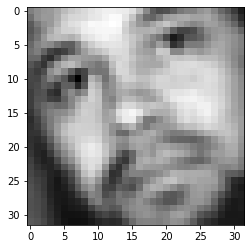

In [48]:
plt.imshow(lfwdata[2].reshape(32,32), cmap='gray')

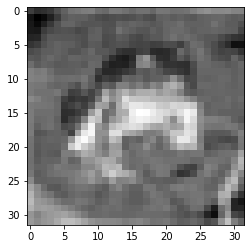

In [49]:
plt.imshow(cifardata[0].reshape(32,32), cmap='gray')

In [50]:
# train-test split
train_test_split = 0.8

# prepare faces
tmp1 = np.round(lfwdata.shape[0]*train_test_split).astype(int)
train_ct1 = np.ones(tmp1) 
test_ct1 = np.ones((lfwdata.shape[0]-tmp1,1))
train_ci1 = lfwdata[:tmp1,:] 
test_ci1 = lfwdata[tmp1:,:]

# prepare non-faces
# note that CIFAR has a lot more images, so here we 
# restrict also this dataset to the same number of images
# as the face dataset!
tmp2 = np.round(lfwdata.shape[0]*train_test_split).astype(int)
train_ct2 = np.zeros(tmp2) 
test_ct2 = np.zeros((lfwdata.shape[0]-tmp2,1))
train_ci2 = cifardata[:tmp2,:] 
test_ci2 = cifardata[tmp2:lfwdata.shape[0],:]

# now concatenate arrays
train_ct12 = np.concatenate((train_ct1,train_ct2),axis=0)
train_ci12 = np.concatenate((train_ci1,train_ci2),axis=0)

test_ct12 = np.concatenate((test_ct1,test_ct2),axis=0)
test_ci12 = np.concatenate((test_ci1,test_ci2),axis=0)

In [51]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2,
          'pin_memory' : True}

train_ct12 = torch.tensor(train_ct12, dtype=torch.float32)
train_ci12 = torch.tensor(train_ci12, dtype=torch.float32)
test_ci12 = torch.tensor(test_ci12, dtype=torch.float32)
test_ct12 = torch.tensor(test_ct12, dtype=torch.float32)

train_dataset = TensorDataset(train_ci12, train_ct12)
test_dataset = TensorDataset(test_ci12, test_ct12)

trainloader = DataLoader(train_dataset, **params)
testloader = DataLoader(test_dataset, **params)

---

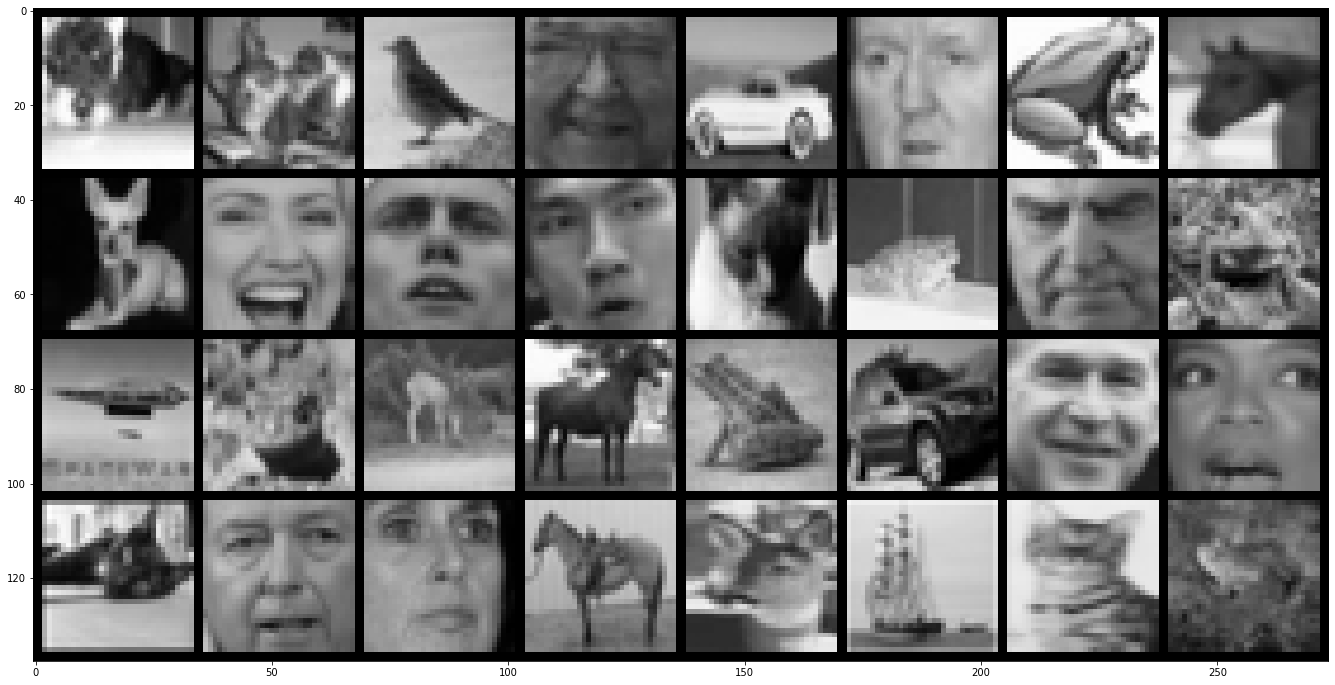

In [52]:
# function to show an image
def imshow(img,labels):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()     # convert back from tensor
    plt.figure(figsize=(36,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # switch channels
    plt.show()


# get some random training images
# this first initializes the dataloader as an iterator
dataiter = iter(trainloader)
# this loads a batch from the train data
# the number of images to load is defined above with batch_size
images, labels = dataiter.next()
# show images using the torchvision utility function
imshow(torchvision.utils.make_grid(images),labels)

In [66]:
# defines a small CNN based on the nn.Module class
class CNN(nn.Module):
    # every nn needs the constructor
    def __init__(self):
        # call the pytorch constructor of the parent class
        super().__init__()
        # first convolutional layer
        # 3 input layers [because of color images]
        # 16 filters with 5x5 pixels each
        self.conv1 = nn.Conv2d(1, 16, 5)
        # pool using 2x2 grid [downsampling]
        self.pool = nn.MaxPool2d(2, 2)
        # second convolutional layer
        # 16 input layers [because of first conv layer]
        # 32 filters with 5x5 pixels each
        self.conv2 = nn.Conv2d(16, 32, 5)
        # fully connected layer [the 32*5*5 needs to calculated]
        self.fc1 = nn.Linear(32 * 5 * 5, 400)
        self.fc2 = nn.Linear(400, 80)
        self.fc3 = nn.Linear(80, 20)
        self.fc4 = nn.Linear(20, 1)


    # every nn needs a forward pass function which takes data x
    # as input and returns x as output
    # the forward function uses the layers defined in the 
    # constructor to make the network architecture
    def forward(self, x):
        # Relu of first CONV and pool
        x = self.pool(F.relu(self.conv1(x)))
        # Relu of second CONV and pool
        x = self.pool(F.relu(self.conv2(x)))
        # flatten output so that it fits into fc layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [67]:
# define the loss - typically, classification is trained with
criterion = nn.BCEWithLogitsLoss()
# define the optimizer that will train the network for us
optimizer = optim.Adam(net.parameters(), lr=0.001)

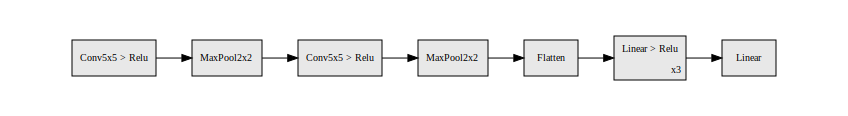

In [68]:
net = CNN().to(device)

# visualize the architecture
import hiddenlayer as hl

hl.build_graph(net, torch.zeros([1, 1, 32, 32]).to(device))

In [69]:
from torchsummary import summary
summary(net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 10, 10]          12,832
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Linear-5                  [-1, 400]         320,400
            Linear-6                   [-1, 80]          32,080
            Linear-7                   [-1, 20]           1,620
            Linear-8                    [-1, 1]              21
Total params: 367,369
Trainable params: 367,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 1.40
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [70]:
history = dict()

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    # load a batch of data
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        # forward + loss + backward + optimize
        outputs = net(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()
        
#         if i % 100 == 99:    # print every 100 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 100))
#             running_loss = 0.0
            
    sys.stdout.write(
    "\r" + f"[Train] Epoch : {epoch+1:^3}"\
    f"  Train Loss: {epoch_loss/len(trainloader):.4}"\
                )
    history.setdefault('loss', []).append(epoch_loss/len(trainloader))


print('\nFinished Training')

[Train] Epoch :  9   Train Loss: 0.009501
Finished Training


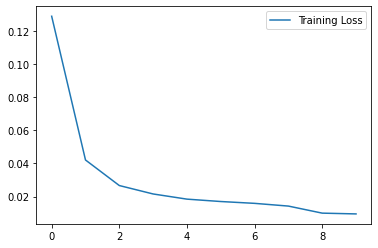

In [71]:
plt.plot(history["loss"], label="Training Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
test_loss = 0.0
for i, data in enumerate(testloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = net(inputs).squeeze(1)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
    
print(test_loss/len(testloader))

---

여기부터는 그냥 교수님 코드 갖다 붙힌거임

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# this will hold all activations for all classes for 
# later plotting of confusion matrix
full_pred = np.empty((len(testloader)*batch_size,len(classes)))
# again no gradients needed
with torch.no_grad():
    # go through all elements in the test set
    for i,data in enumerate(testloader):
        # again push them to device
        inputs, labels = data[0].to(device), data[1].to(device)
        # we need the forward pass
        outputs = net(inputs)
        # and store for later use
        full_pred[i*batch_size:i*batch_size+batch_size,:]=outputs.cpu().numpy()
        
        # the predicted class is the maximum across the
        # batch for the second dimension
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

In [ ]:
import itertools
# function to plot confusion matrix
# adapted from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = '{} Accuracy: {:.2f}'.format(
            title,np.mean(np.diag(cm)))
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=26)
    cbar = plt.colorbar()
    # this is needed to adjust the small ticklabels on the colorbar
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(20)
    # show the x and y ticks with nice rotation if needed
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=22)
    plt.yticks(tick_marks, classes,fontsize=22)

    fmt = '.2f' if normalize else 'd'
    # adjust threshold for black / white font
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=22
                )

    plt.tight_layout()
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label',fontsize=22)

In [ ]:
# make confusion matrix
cm = np.zeros((len(classes),len(classes)))
# the true labels
tr = testset.targets
# the predicted labels
pr = full_pred.argmax(axis=1)
# add for each pair
for i in range(len(testset.targets)):
    cm[tr[i],pr[i]]+=1
    
plot_confusion_matrix(cm,classes,normalize=True)